In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ['LANGSMITH_API_KEY'] = os.getenv('LANGSMITH_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY')
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_PROJECT'] = 'langchain_quickstart'

In [2]:
# List all the available models
# import anthropic
# client = anthropic.Anthropic()
# client.models.list(limit=20)

In [3]:
# testing LLM
# from langchain_anthropic import ChatAnthropic

# llm = ChatAnthropic(model="claude-3-5-haiku-20241022")
# llm.invoke("hello")


# Part 1: Build a Basic Chatbot

Start by creating a StateGraph. A StateGraph object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# State is a TypedDict with one key: messages (in this case)
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # `add_messages` function merges two lists of messages, updating existing messages by ID.
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

Next, add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.

In [5]:
# calling groq llm (free to use)
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg.content

'I love programming in French is: "J\'aime programmer."'

In [6]:
from langchain_anthropic import ChatAnthropic
# llm = ChatAnthropic(model="claude-3-5-haiku-20241022") # we'll use llm from groq



def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

Notice how the chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key "messages". This is the basic pattern for all LangGraph node functions.

The add_messages function in our State will append the llm's response messages to whatever messages are already in the state.

In [7]:
# add an entry point
graph_builder.add_edge(START, "chatbot") # start -> chatbot

# set a finish point
graph_builder.add_edge("chatbot", END) # chatbot -> end

Finally, we'll want to be able to run our graph. To do so, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.

In [8]:
graph = graph_builder.compile()

You can visualize the graph using the get_graph method and one of the "draw" methods, like draw_ascii or draw_png.

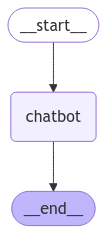

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [10]:
# generator object in Python
graph.stream({"messages": [{"role": "user", "content": "write a note on linear programming"}]})

<generator object Pregel.stream at 0x000002A54035BA60>

In [11]:
for event in graph.stream({"messages": [{"role": "user", "content": "write a note on linear programming"}]}):
        print(event['chatbot']['messages'][0])

content='Linear Programming (LP) is a mathematical optimization technique used to find the optimal solution for a problem with linear objectives and constraints. LP problems involve optimizing a linear objective function, subject to linear equality and inequality constraints. The variables in an LP problem are continuous and can take any value within their specified bounds.\n\nLP problems can be solved using simplex method, dual simplex method, or interior point method. These methods are based on the fundamental theorem of LP, which states that an LP problem has an optimal solution if and only if its feasible region is non-empty and bounded.\n\nLP has numerous applications in various fields such as operations research, management science, economics, and engineering. It can be used to optimize production processes, allocate resources, schedule tasks, and make decisions in complex systems. LP is a powerful tool for decision making and can help organizations to improve their efficiency, r

In [12]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("\nGoodbye!")
            break
        print('\nuser:', user_input.lower())
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break


user: hi
Assistant: Hello! How can I help you today? If you have any questions or need assistance with

* General knowledge questions
* Explanations of concepts
* Writing assistance
* Code examples
* Math problems
* Language translations
* Or anything else, just let me know! I'm here to help.

Goodbye!


# Part 2: 🛠️ Enhancing the Chatbot with Tools

In [13]:
# search tool
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 | by Kamal Dhungana | Medium Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 LangGraph — State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sharing insights for AI community growth Follow"},
 {'url': 'https://blog.langchain

In [14]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm = ChatAnthropic(model="claude-3-5-haiku-20241022")
# llm = ChatGroq(
#     model="mixtral-8x7b-32768",
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     max_retries=2,
# )
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools) # now the llm know the exact json format to call the tools


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a BasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

In [15]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools} # dic of tool name and the tool

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1] # last AI message
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls: # tool_calls is a list of tools to call
            tool_result = self.tools_by_name[tool_call["name"]].invoke( 
                tool_call["args"]
            ) # select the tool by name and call it with the args
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool]) # create a tool node and add the Tavily Search tool to it
graph_builder.add_node("tools", tool_node)

 route_tools: that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling add_conditional_edges, which tells the graph that whenever the chatbot node completes to check this function to see where to go next.

The condition will route to tools if tool calls are present and END if not

In [16]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1] 
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

Notice that conditional edges start from a single node. This tells the graph "any time the 'chatbot' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly.

function returns the END string if no tool calls are made. When the graph transitions to END, it has no more tasks to complete and ceases execution. Because the condition can return END, we don't need to explicitly set a finish_point this time. Our graph already has a way to finish!

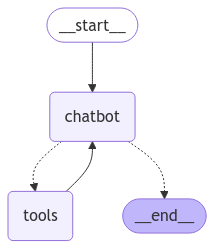

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I assist you today? I'm ready to help you with any questions or tasks you might have. Whether you need information, research, or support with something specific, feel free to ask.
Assistant: [{'text': 'Let me search for the current President of the United States.', 'type': 'text'}, {'id': 'toolu_01JwM1iq9AR8pQvpT5pebojt', 'input': {'query': 'Current President of the United States 2024'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"url": "https://www.britannica.com/event/United-States-presidential-election-of-2024", "content": "United States presidential election of 2024 | Background, Candidates, Donald Trump, Joe Biden, Indictments, & Facts | Britannica Ask the Chatbot Games & Quizzes History & Society Science & Tech Biographies Animals & Nature Geography & Travel Arts & Culture ProCon Money Videos United States presidential election of 2024, American election, held on November 5, 2024, in which former Republican president Donald T

The full code for the graph we've created in this section is reproduced below, replacing our BasicToolNode for the prebuilt ToolNode, and our route_tools condition with the prebuilt tools_condition

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-haiku-20241022")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

In [20]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Goodbye!


# Part 3: Adding Memory to the Chatbot

If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. 

In [21]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Notice we're using an in-memory checkpointer. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to use SqliteSaver or PostgresSaver and connect to your own DB.

In [22]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-haiku-20241022")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [23]:
graph = graph_builder.compile(checkpointer=memory)

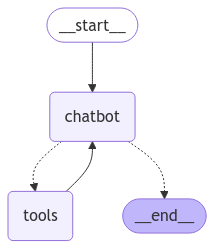

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [25]:
config = {"configurable": {"thread_id": "1"}}

In [26]:
user_input = "Hi there! My name is Padayappa."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Padayappa.
================================== Ai Message ==================================

Hello Padayappa! It's nice to meet you. How are you doing today? Is there anything I can help you with?


Note: The config was provided as the second positional argument when calling our graph. It importantly is not nested within the graph inputs ({'messages': []}).
Let's ask a followup: see if it remembers your name.

In [27]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Padayappa. I'll keep that in mind during our conversation. Is there something specific you'd like assistance with today?


Try this using a different config.


In [28]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I apologize, but I do not have persistent memory between conversations. Each interaction starts fresh, so I don't have a previous context of your name. If you'd like, you can tell me your name now, and I'll be happy to use it during our current conversation.


By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's state for a given config at any time, call get_state(config).

In [29]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Padayappa.', additional_kwargs={}, response_metadata={}, id='5a7b457f-8bce-4dbb-b2b8-dfbbfc7d56c8'), AIMessage(content="Hello Padayappa! It's nice to meet you. How are you doing today? Is there anything I can help you with?", additional_kwargs={}, response_metadata={'id': 'msg_013KDpPks7PzWzixXYbQQ4cH', 'model': 'claude-3-5-haiku-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 378, 'output_tokens': 31}}, id='run-0cb7c884-3bd7-4e9b-ad9c-aa850ec2eecd-0', usage_metadata={'input_tokens': 378, 'output_tokens': 31, 'total_tokens': 409, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='86958865-c2ed-4426-99e5-0b873f5bd963'), AIMessage(content="Yes, I remember your name is Padayappa. I'll keep that in mind during

In [30]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

# Part 4: Human-in-the-loop

LangGraph's persistence layer supports human-in-the-loop workflows, allowing execution to pause and resume based on user feedback. The primary interface to this functionality is the interrupt function. Calling interrupt inside a node will pause execution. Execution can be resumed, together with new input from a human, by passing in a Command. interrupt is ergonomically similar to Python's built-in input(), with some caveats. We demonstrate an example below.

In [32]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-haiku-20241022")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}  # We only return one message at a time


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

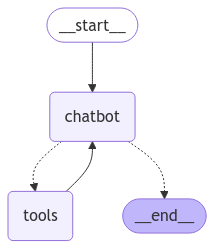

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [34]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================

[{'text': "I'll help you request human assistance for guidance on building an AI agent.", 'type': 'text'}, {'id': 'toolu_01GWDUxrWnxnctF7rx4s69px', 'input': {'query': "I'm looking for expert guidance on building an AI agent. Could you provide advice on:\n1. Key considerations when designing an AI agent\n2. Best practices for development\n3. Recommended frameworks or tools\n4. Potential challenges to anticipate\n5. Strategies for ensuring ethical and effective AI agent implementation\n\nWhat specific insights can you share to help me successfully develop an AI agent?"}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01GWDUxrWnxnctF7rx4s69px)
 Call ID: toolu_01GWDUxrWnxnctF7rx4s69px
  Args:
    que

The chatbot generated a tool call, but then execution has been interrupted! Note that if we inspect the graph state, we see that it stopped at the tools node:

In [35]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

Let's take a closer look at the human_assistance tool:

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

Similar to Python's built-in input() function, calling interrupt inside the tool will pause execution. Progress is persisted based on our choice of checkpointer-- so if we are persisting with Postgres, we can resume at any time as long as the database is alive. Here we are persisting with the in-memory checkpointer, so we can resume any time as long as our Python kernel is running.

To resume execution, we pass a Command object containing data expected by the tool. The format of this data can be customized based on our needs. Here, we just need a dict with a key "data":

In [36]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "I'll help you request human assistance for guidance on building an AI agent.", 'type': 'text'}, {'id': 'toolu_01GWDUxrWnxnctF7rx4s69px', 'input': {'query': "I'm looking for expert guidance on building an AI agent. Could you provide advice on:\n1. Key considerations when designing an AI agent\n2. Best practices for development\n3. Recommended frameworks or tools\n4. Potential challenges to anticipate\n5. Strategies for ensuring ethical and effective AI agent implementation\n\nWhat specific insights can you share to help me successfully develop an AI agent?"}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01GWDUxrWnxnctF7rx4s69px)
 Call ID: toolu_01GWDUxrWnxnctF7rx4s69px
  Args:
    query: I'm looking for expert guidance on building an AI agent. Could you provide advice on:
1. Key considerations when designing an AI agent
2. Best practices for development


Our input has been received and processed as a tool message. Review this call's LangSmith trace to see the exact work that was done in the above call. Notice that the state is loaded in the first step so that our chatbot can continue where it left off.

# Part 5: Customizing State

So far, we've relied on a simple state with one entry-- a list of messages. You can go far with this simple state, but if you want to define complex behavior without relying on the message list, you can add additional fields to the state

In [37]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

Adding this information to the state makes it easily accessible by other graph nodes (e.g., a downstream node that stores or processes the information), as well as the graph's persistence layer.

Here, we will populate the state keys inside of our human_assistance tool. This allows a human to review the information before it is stored in the state. We will again use Command, this time to issue a state update from inside our tool.

In [38]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [45]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [46]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================

[{'text': "Certainly! I'll start by searching for information about LangGraph's release date using the Tavily search engine, and then I'll use the human_assistance tool for review. Let's begin with the search.", 'type': 'text'}, {'id': 'toolu_01FM91qLYDTKSee3SWq1doQt', 'input': {'query': 'LangGraph release date'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01FM91qLYDTKSee3SWq1doQt)
 Call ID: toolu_01FM91qLYDTKSee3SWq1doQt
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph/releases", "content": "R

In [47]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Thank you for providing the search results. Based on the information from the Tavily search, I can see that LangGraph is an actively maintained project, but I couldn't find a specific initial release date. The most recent version mentioned in the search results is 0.2.70, which was released on February 6, 2025 (this appears to be a future date, so it might be an error in the data).\n\nSince we don't have a definitive initial release date, let's use the human_assistance tool to review this information and potentially get more accurate details about LangGraph's release.", 'type': 'text'}, {'id': 'toolu_01YW628Xz74gqveMX9eY1WfZ', 'input': {'name': 'LangGraph Release Date', 'birthday': 'unknown'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01YW628Xz74gqveMX9eY1WfZ)
 Call ID: toolu_01YW628Xz74gqveMX9eY1WfZ
  Args:
    name: LangGraph Release Date
    birth

In [48]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

## Manually updating state

LangGraph gives a high degree of control over the application state. For instance, at any point (including when interrupted), we can manually override a key using
graph.update_state:

In [49]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff368b-0841-610b-8006-e1fc49745515'}}

If we call graph.get_state, we can see the new value is reflected:

In [50]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

# Part 6: Time Travel

But what if you want to let your user start from a previous response and "branch off" to explore a separate outcome? Or what if you want users to be able to "rewind" your assistant's work to fix some mistakes or try a different strategy (common in applications like autonomous software engineers)?

You can create both of these experiences and more using LangGraph's built-in "time travel" functionality.

In this section, you will "rewind" your graph by fetching a checkpoint using the graph's get_state_history method. You can then resume execution at this previous point in time.

In [51]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-haiku-20241022")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [52]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "I'll search for some information about LangGraph to help you learn more about it.", 'type': 'text'}, {'id': 'toolu_01VjSxmj94QeDQmSrBaHd2Ud', 'input': {'query': 'LangGraph AI library LangChain library purpose and features'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01VjSxmj94QeDQmSrBaHd2Ud)
 Call ID: toolu_01VjSxmj94QeDQmSrBaHd2Ud
  Args:
    query: LangGraph AI library LangChain library purpose and features
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/watch?v=7zeBr__G8dU", "content": "... Features: - **Cyclic Coordination:** LangGraph facilitates cyclic ... LangGraph: Langchain's Ne

In [53]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

[{'text': 'Let me search for some insights on building autonomous agents with LangGraph to give you some guidance:', 'type': 'text'}, {'id': 'toolu_01Fij8FoM9FkjE7VqYEdpcYj', 'input': {'query': 'How to build autonomous agents using LangGraph step-by-step tutorial'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01Fij8FoM9FkjE7VqYEdpcYj)
 Call ID: toolu_01Fij8FoM9FkjE7VqYEdpcYj
  Args:
    query: How to build autonomous agents using LangGraph step-by-step tutorial
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://medium.com/@lorevanoudenhove/how-to-build-ai-agents-with-langgraph-a-step-by-step-guide-5d84d9c7e832", "conte

Now that we've had the agent take a couple steps, we can replay the full state history to see everything that occurred.

In [54]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  12 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  11 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  10 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  9 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  8 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------

Notice that checkpoints are saved for every step of the graph. This spans invocations so you can rewind across a full thread's history. We've picked out to_replay as a state to resume from. This is the state after the chatbot node in the second graph invocation above.
Resuming from this point should call the action node next.

In [55]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1eff3694-c794-6c94-8005-d28a7f54c6ff'}}


Notice that the checkpoint's config (to_replay.config) contains a checkpoint_id timestamp. Providing this checkpoint_id value tells LangGraph's checkpointer to load the state from that moment in time. Let's try it below:

In [56]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Based on the research, here's a comprehensive overview of LangGraph:

What is LangGraph?
- LangGraph is a library within the LangChain ecosystem specifically designed for creating and managing complex AI agent workflows
- It provides a graph-based framework for coordinating multiple Large Language Model (LLM) agents or chains

Key Features:
1. Graph-Based Workflow Management
- Allows developers to create structured, dynamic AI workflows
- Supports cyclic graphs for iterative processes
- Enables complex multi-agent coordination

2. Advanced State Management
- Provides persistent state management
- Allows tracking and maintaining state across different stages of an AI workflow
- Simplifies the development of stateful AI applications

3. Flexible Agent Coordination
- Helps create sophisticated chatbots and multi-agent systems
- Enables intricate decision-making pipelines
- Focuses on high-level logic rather 

Notice that the graph resumed execution from the **action** node. You can tell this is the case since the first value printed above is the response from our search engine tool.